In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys, copy, emcee, corner

%matplotlib inline
%load_ext autoreload

sys.path.append('./ligbind/')
import ligbind as lb

In [9]:
WT_08_lbl, WT_08_rtot, WT_08_lig, WT_08_sat = lb.datprep('Data/EGFR_WT_08_Sat.csv','Data/EGFR_WT_08_Rtot.csv')
WT_09_lbl, WT_09_rtot, WT_09_lig, WT_09_sat = lb.datprep('Data/EGFR_WT_09_Sat.csv','Data/EGFR_WT_09_Rtot.csv')
WT_11_lbl, WT_11_rtot, WT_11_lig, WT_11_sat = lb.datprep('Data/EGFR_WT_11_Sat.csv','Data/EGFR_WT_11_Rtot.csv')
KI_08_lbl, KI_08_rtot, KI_08_lig, KI_08_sat = lb.datprep('Data/EGFR_KI_08_Sat.csv','Data/EGFR_KI_08_Rtot.csv')
KI_09_lbl, KI_09_rtot, KI_09_lig, KI_09_sat = lb.datprep('Data/EGFR_KI_09_Sat.csv','Data/EGFR_KI_09_Rtot.csv')
KI_09c_lbl, KI_09c_rtot, KI_09c_lig, KI_09c_sat = lb.datprep('Data/EGFR_KI_09c_Sat.csv','Data/EGFR_KI_09c_Rtot.csv')

hootie hoo! the indices match!
hootie hoo! the indices match!
hootie hoo! the indices match!
hootie hoo! the indices match!
hootie hoo! the indices match!
hootie hoo! the indices match!


In [10]:
WT_08_parm = np.array([4.6,5.3,0.34,530.])
WT_09_parm = np.array([4.2,2.0,0.19,860.])
WT_11_parm = np.array([3.4,1.1,0.15,240.])
KI_08_parm = np.array([0.36,48.,0.79,0.61])
KI_09_parm = np.array([0.17,61.,1.9,1.0])
KI_09c_parm = np.array([0.15,75.,0.56,3.7])

In [11]:
guess = np.array([0.05,0.05,0.05,0.05,0.05,0.05])

In [12]:
lsbnds = (tuple(1e-5 for i in range(6)),tuple(1e-1 for i in range(6)))

In [13]:
sats = [WT_08_sat,WT_09_sat,WT_11_sat,KI_08_sat,KI_09_sat,KI_09c_sat]
ligs = [WT_08_lig,WT_09_lig,WT_11_lig,KI_08_lig,KI_09_lig,KI_09c_lig]
parms = [WT_08_parm,WT_09_parm,WT_11_parm,KI_08_parm,KI_09_parm,KI_09c_parm]
rtots = [WT_08_rtot,WT_09_rtot,WT_11_rtot,KI_08_rtot,KI_09_rtot,KI_09c_rtot]
guesses = [guess,guess[:-1],guess,guess,guess,guess] #all data sets have 6 rtots except one, which has 5
bounds = [lsbnds,(lsbnds[0][:-1],lsbnds[1][:-1]),lsbnds,lsbnds,lsbnds,lsbnds] #all data sets have 6 rtots except one, which has 5

In [15]:
def rtot_objfun(guess,parm,lig,dat):
    datac = np.concatenate(dat)
    calc = lb.models.wymfunc(parm,lig,guess)
    
    return (calc-datac)

In [16]:
lssqrs_rtot_sols = [sp.optimize.least_squares(rtot_objfun,guesses[i],args=(parms[i],ligs[i],sats[i]),bounds=bounds[i],ftol=1e-14).x for i in range(len(sats))]

In [17]:
lssqrs_rtot_sols

[array([ 0.00143878,  0.00242228,  0.00339179,  0.0027181 ,  0.01216361,
         0.02594478]),
 array([ 0.00058892,  0.00254376,  0.00642976,  0.01263456,  0.05509229]),
 array([ 0.0011934 ,  0.00351278,  0.00608287,  0.01967875,  0.03012646,
         0.0925015 ]),
 array([ 0.00119181,  0.00302457,  0.00653417,  0.00631584,  0.01723065,
         0.02554929]),
 array([ 0.0005009 ,  0.00159331,  0.00328982,  0.00478844,  0.0154645 ,
         0.01698975]),
 array([ 0.0003901 ,  0.00122332,  0.00239967,  0.00279824,  0.00689825,
         0.01002052])]

In [18]:
for i in rtots:
    print(i)

[ 0.001439  0.002422  0.003392  0.002718  0.01216   0.02594 ]
[ 0.0005889  0.002544   0.00643    0.01263    0.05509  ]
[ 0.001193  0.003513  0.006083  0.01968   0.03013   0.0925  ]
[ 0.001192  0.003025  0.006534  0.006316  0.01723   0.02555 ]
[ 0.0005009  0.001593   0.00329    0.004788   0.01546    0.01699  ]
[ 0.0003901  0.001223   0.0024     0.002798   0.006898   0.01002  ]


In [19]:
#vary all Wym model parameters
#variance weighted by y-value (not y squared)
def lnlik4p(parms,rtot,data,ligs):
    datac = np.concatenate(data)
    modparms = parms[0:-1]
    rtots = rtot
    f = parms[-1]
    model = lb.models.wymfunc(modparms,ligs,rtots)
    invsig2 = 1.0/np.square(f*datac) #do I need to change this to DATAC?
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log(invsig2)))

l6+ma

In [20]:
nll = lambda *args: -lnlik4p(*args)

In [21]:
g1 = np.array([4.,6.,13.,170.,0.01])
g2 = np.array([1.,4.,0.5,100.,0.01])
g3 = np.array([15.,6.,0.8,245.,0.01])

In [73]:
bnds = ((1e-12,1000.),(0.0001,1000.),(0.0001,1000.),(0.001,10000.),(1e-6,0.5))

In [62]:
dartots = [sp.optimize.minimize(nll,g1,args=(rtots[i],ligs[i],sats[i]),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12}).x for i in range(len(sats))] 

In [43]:
def lnlik4pNW(parms,rtot,data,ligs):
    datac = np.concatenate(data)
    modparms = parms[0:-1]
    rtots = rtot
    f = parms[-1]
    model = lb.models.wymfunc(modparms,ligs,rtots)
    invsig2 = 1.0/np.square(f*datac) #do I need to change this to DATAC?
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log(invsig2)))

In [44]:
nllNW = lambda *args: -lnlik4pNW(*args)

In [45]:
nllNW(g1,rtots[1],sats[1],ligs[1])

578210.11482919136

In [69]:
sp.optimize.minimize(nll,,args=(rtots[5],sats[5],ligs[5]),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12})

TypeError: only integer arrays with one element can be converted to an index

In [48]:
parms[5]

array([  0.15,  75.  ,   0.56,   3.7 ])

In [58]:
parms2 = [np.append(i,0.01) for i in parms]

In [57]:
parms

[array([  4.60000000e+00,   5.30000000e+00,   3.40000000e-01,
          5.30000000e+02]),
 array([  4.20000000e+00,   2.00000000e+00,   1.90000000e-01,
          8.60000000e+02]),
 array([  3.40000000e+00,   1.10000000e+00,   1.50000000e-01,
          2.40000000e+02]),
 array([  0.36,  48.  ,   0.79,   0.61]),
 array([  0.17,  61.  ,   1.9 ,   1.  ]),
 array([  0.15,  75.  ,   0.56,   3.7 ])]

In [79]:
sp.optimize.minimize(nll,parms2[1],args=(rtots[1],sats[1],ligs[1]),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-16})

      fun: -180.89322488190243
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  5.68434189e-06,   8.52651283e-06,  -2.84217094e-06,
         2.84217094e-06,  -2.84217094e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 804
      nit: 81
   status: 0
  success: True
        x: array([  3.96085660e+00,   1.26911497e+00,   4.70042900e-01,
         8.30647321e+02,   1.59626826e-01])

In [78]:
parms2[0]

array([  4.60000000e+00,   5.30000000e+00,   3.40000000e-01,
         5.30000000e+02,   1.00000000e-02])

In [61]:
rtots

[array([ 0.001439,  0.002422,  0.003392,  0.002718,  0.01216 ,  0.02594 ]),
 array([ 0.0005889,  0.002544 ,  0.00643  ,  0.01263  ,  0.05509  ]),
 array([ 0.001193,  0.003513,  0.006083,  0.01968 ,  0.03013 ,  0.0925  ]),
 array([ 0.001192,  0.003025,  0.006534,  0.006316,  0.01723 ,  0.02555 ]),
 array([ 0.0005009,  0.001593 ,  0.00329  ,  0.004788 ,  0.01546  ,  0.01699  ]),
 array([ 0.0003901,  0.001223 ,  0.0024   ,  0.002798 ,  0.006898 ,  0.01002  ])]

In [66]:
dartots

[array([ 0.37245351,  0.001     ,  0.00171752,  0.01      ,  0.5       ]),
 array([  4.73797674e-01,   9.28538795e-03,   1.00000000e+03,
          9.70749778e+01,   5.00000000e-01]),
 array([  1.00000000e-03,   1.46213139e+00,   8.28219618e+00,
          1.00635108e+02,   5.00000000e-01]),
 array([  1.43751417e+00,   1.43874425e+00,   1.39111289e+01,
          1.00000000e+04,   5.00000000e-01]),
 array([  6.79969313e+00,   1.07919028e+00,   8.04892390e+00,
          1.00000000e+04,   5.00000000e-01]),
 array([  2.04646165e+00,   9.24530478e-03,   1.00000000e+03,
          1.00000000e+04,   5.00000000e-01])]

In [67]:
rtots

[array([ 0.001439,  0.002422,  0.003392,  0.002718,  0.01216 ,  0.02594 ]),
 array([ 0.0005889,  0.002544 ,  0.00643  ,  0.01263  ,  0.05509  ]),
 array([ 0.001193,  0.003513,  0.006083,  0.01968 ,  0.03013 ,  0.0925  ]),
 array([ 0.001192,  0.003025,  0.006534,  0.006316,  0.01723 ,  0.02555 ]),
 array([ 0.0005009,  0.001593 ,  0.00329  ,  0.004788 ,  0.01546  ,  0.01699  ]),
 array([ 0.0003901,  0.001223 ,  0.0024   ,  0.002798 ,  0.006898 ,  0.01002  ])]

In [83]:
a = np.concatenate([sats[0],sats[1],sats[2]])
b = np.concatenate([ligs[0],ligs[1],ligs[2]])
c = np.concatenate([rtots[0],rtots[1],rtots[2]])

In [90]:
jntwt = sp.optimize.minimize(nll,parms2[1],args=(c,a,b),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-16})

In [145]:
a1 = np.concatenate([sats[0],sats[1],sats[2]])
b1 = np.concatenate([ligs[0],ligs[1],ligs[2]])
c1 = np.concatenate([rtots[0],rtots[1],rtots[2]])

In [146]:
sp.optimize.minimize(nll,parms2[1],args=(c1,a1,b1),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-16})

      fun: -546.78387478653372
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,   0.00000000e+00,  -1.13686838e-05,
         1.13686838e-05,   2.02362571e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 666
      nit: 65
   status: 0
  success: True
        x: array([  3.69129379e+00,   7.11266637e-01,   1.63862468e-02,
         2.11598861e+02,   1.89484959e-01])

In [147]:
sp.optimize.minimize(nll,parms2[3],args=(c1,a1,b1),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-16})

      fun: -546.7838748004649
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,   0.00000000e+00,  -1.13686838e-05,
         0.00000000e+00,   0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 714
      nit: 86
   status: 0
  success: True
        x: array([  3.69126285e+00,   7.11253746e-01,   1.63769112e-02,
         2.11590929e+02,   1.89484809e-01])

In [148]:
ndim4p, nwalkers4p = 5, 100
pos4p = [np.random.normal(1.,0.1)*jntwt.x for i in range(nwalkers4p)]

In [149]:
sampler = emcee.EnsembleSampler(nwalkers4p,ndim4p,lnprob4p,args=(bnds,c,a,b))

In [150]:
sampler.run_mcmc(pos4p,2000);

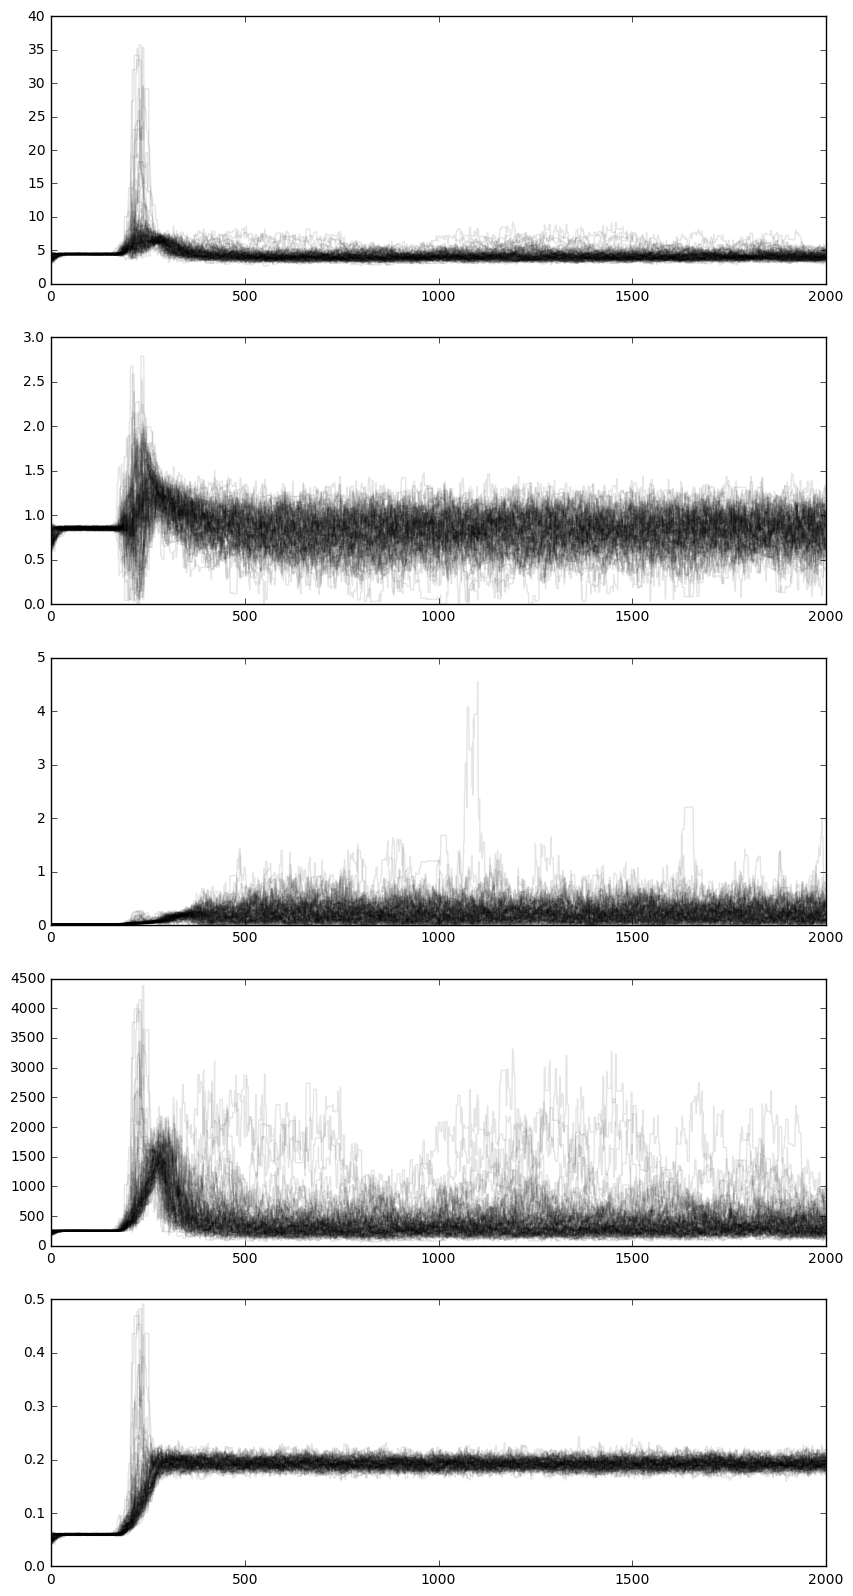

In [151]:
fig = plt.figure(figsize=(10,20))
for i in range(5):
    ax1 = fig.add_subplot(5,1,(i+1))
    ax1.plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.1);

In [152]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim4p))

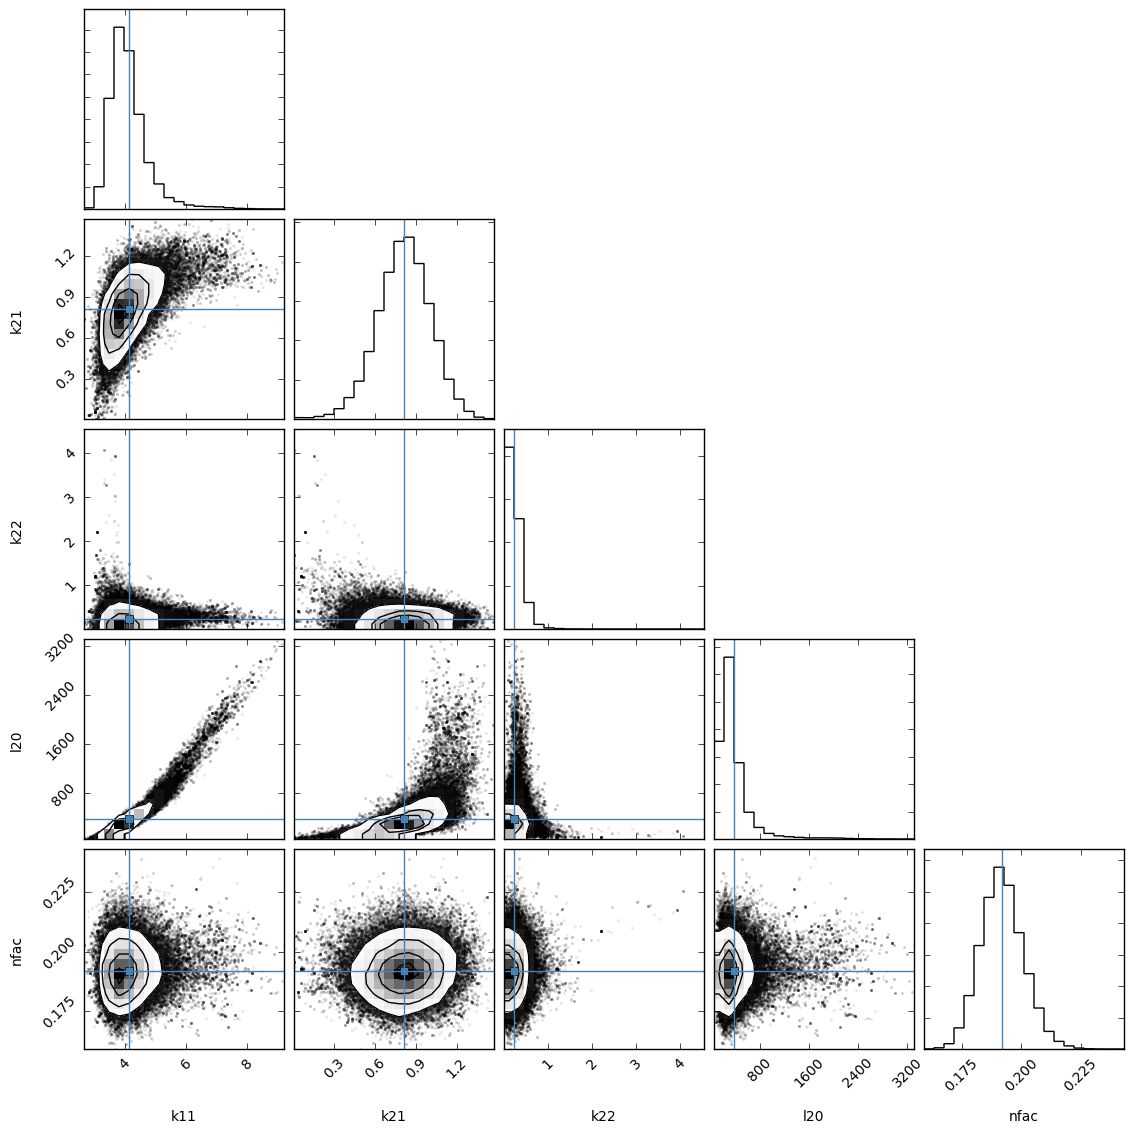

In [153]:
fig=corner.corner(samples, labels=['k11','k21','k22','l20','nfac'],truths=np.mean(samples,axis=0))

In [109]:
np.median(samples,axis=0)

array([  3.97661419e+00,   8.09060237e-01,   1.99058725e-01,
         2.97516869e+02,   1.92095090e-01])

In [98]:
prcs = np.percentile(samples, [16, 50, 84], axis=0)

In [108]:
prcs[:,2]

array([ 0.06543388,  0.19905873,  0.38564555])

In [116]:
#FIX BOUNDS AND ALSO VARY RTOT
bnds2 = ((1e-12,1000.),(0.0001,1000.),(0.0001,1000.),(0.001,10000.),(0.01,0.1))

In [117]:
new_pos = jntwt.x
new_pos[-1] = 0.05
new_pos

array([  3.69129379e+00,   7.11266637e-01,   1.63862468e-02,
         2.11598861e+02,   5.00000000e-02])

In [119]:
pos4p2 = [np.random.normal(1.,0.1)*new_pos for i in range(nwalkers4p)]

In [120]:
sampler2 = emcee.EnsembleSampler(nwalkers4p,ndim4p,lnprob4p,args=(bnds2,c,a,b))

In [121]:
sampler2.run_mcmc(pos4p2,2000);

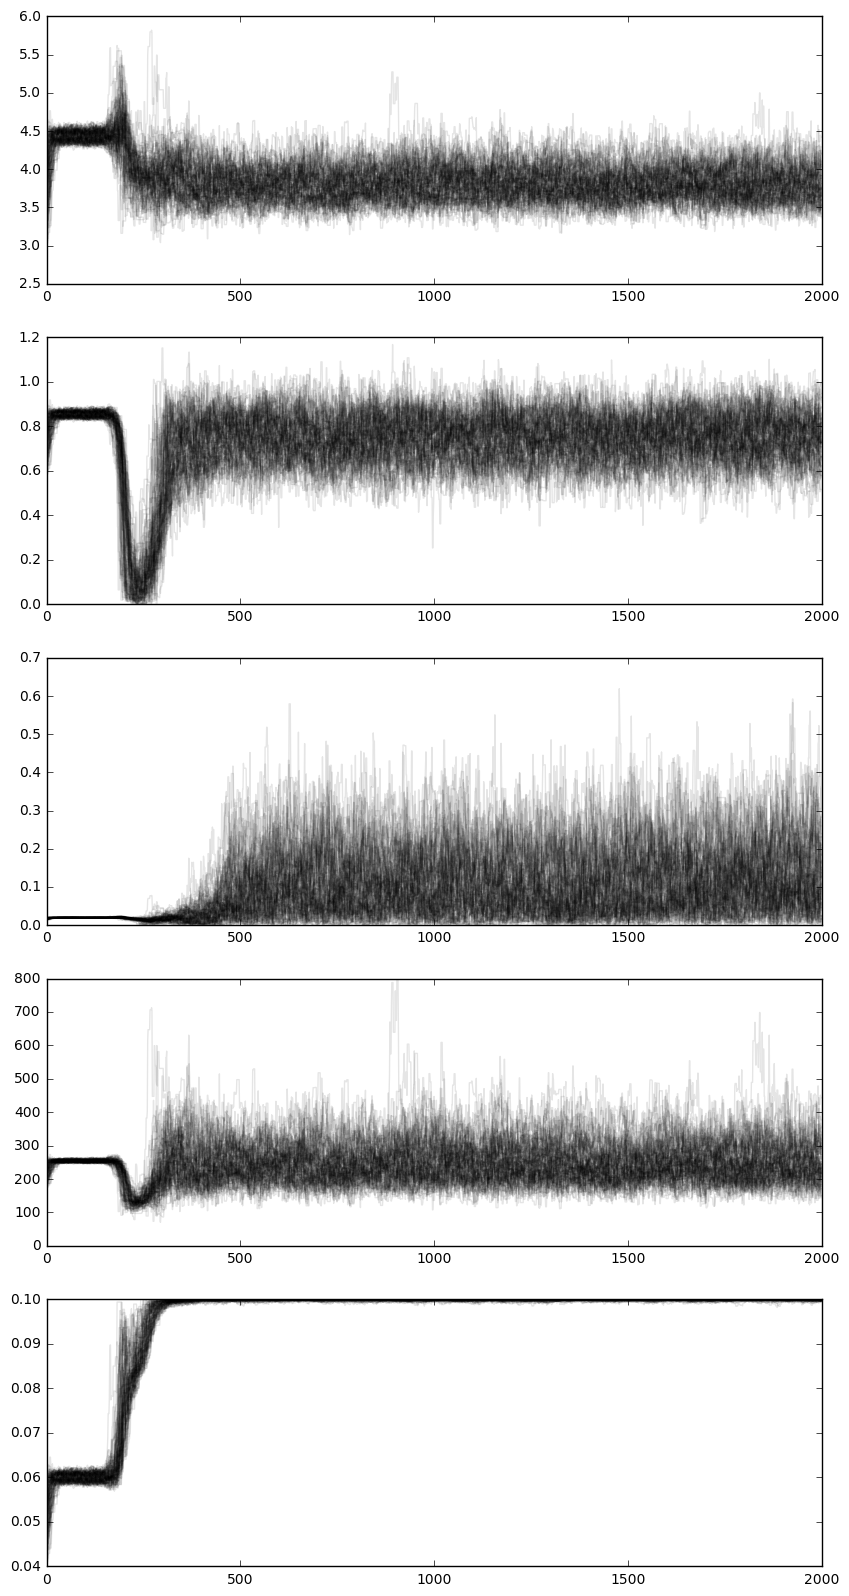

In [122]:
fig = plt.figure(figsize=(10,20))
for i in range(5):
    ax1 = fig.add_subplot(5,1,(i+1))
    ax1.plot(sampler2.chain[:,:,i].T, '-', color='k', alpha=0.1);

In [123]:
samples2 = sampler2.chain[:, 500:, :].reshape((-1, ndim4p))

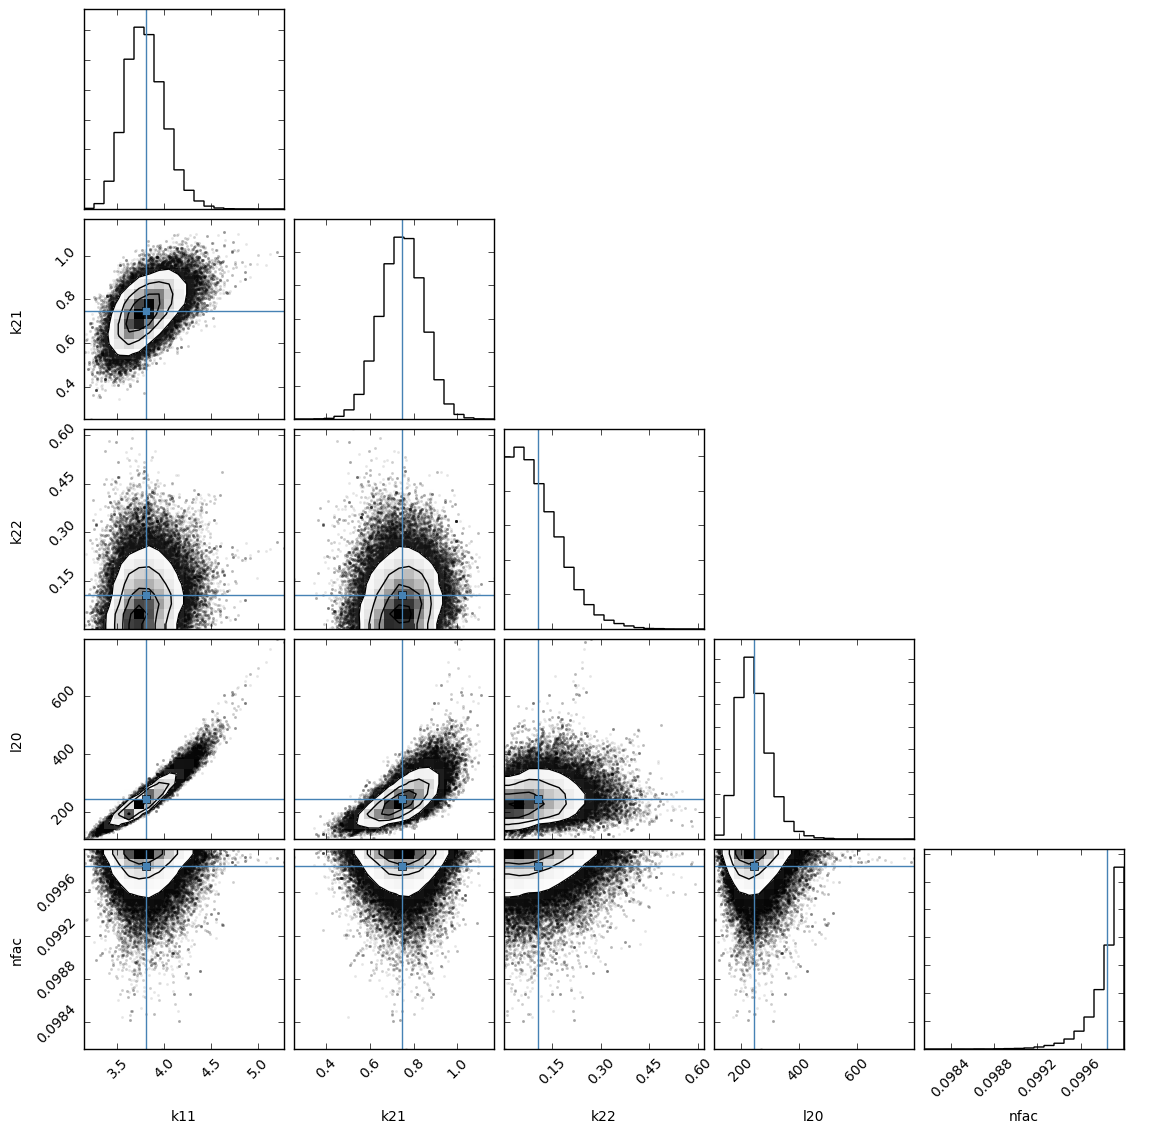

In [124]:
fig=corner.corner(samples2, labels=['k11','k21','k22','l20','nfac'],truths=np.mean(samples2,axis=0))

In [125]:
prcs2 = np.percentile(samples2, [16, 50, 84], axis=0)

In [129]:
prcs2[:,0],prcs[:,0]

(array([ 3.59835422,  3.78528024,  4.00340597]),
 array([ 3.57977838,  3.97661419,  4.55079376]))

{'boxes': [<matplotlib.lines.Line2D at 0x110eda048>,
 'caps': [<matplotlib.lines.Line2D at 0x110ee1a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x110ee7c88>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x110ee7470>,
 'whiskers': [<matplotlib.lines.Line2D at 0x110edaa20>,
  <matplotlib.lines.Line2D at 0x110ef1ba8>]}

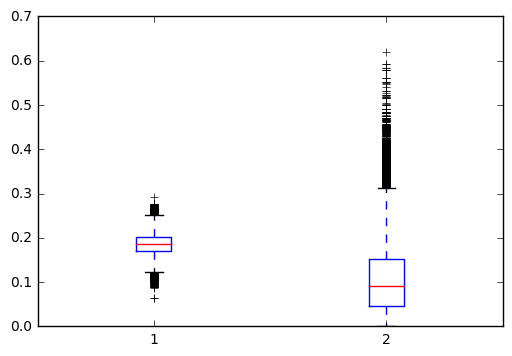

In [140]:
plt.boxplot([samples2[:,1]/4,samples2[:,2]])

In [144]:
np.median(samples[:,2])

0.19905872539158803